# Estimation of parameters in computational / predictive models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, uniform

## Part 1. Frequentist approach

### Normal equations

Normal equations: Say we have a linear relationship between a QoI $y$ and a dependent variable $x$ (such as time or space) as follows:
$$y_{i}=\theta_{1} + \theta_{2} \frac{x_{i}}{12} + \theta_{3} \left( \frac{x_{i}}{12} \right)^2 + \varepsilon_{i}$$
The data is given in the table below. The noise is Gaussian, $\varepsilon_{i} \sim N(0, 3^2)$.

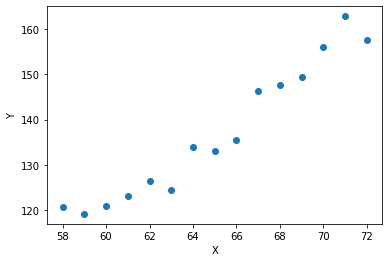

In [2]:
data_x = np.arange(58, 73).reshape((-1, 1))
data_y = np.array([115, 117, 120, 123, 126, 129, 132, 135, 139, 142, 146, 150, 154, 159, 164]) + 3. * np.random.randn(15)
data_y = data_y.reshape((-1, 1))   # transform into a column vector
plt.scatter(data_x, data_y)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [3]:
# design matrix H
H = np.concatenate([np.ones((15, 1)), data_x/12, (data_x/12)**2], axis=1)
print(H.shape)

(15, 3)


Compute the OLS estimator of theta - use the normal equations given in class

In [4]:
# Use the normal equations
theta_ols = np.matmul(np.matmul(np.linalg.inv(np.matmul(H.T, H)), H.T), data_y)
print(theta_ols)

[[ 425.79164165]
 [-146.28952047]
 [  17.09492517]]


Confidence in results? Compute covariance of sampling distribution, the diagonal terms contained the standard errors squared.

In [5]:
# Covariance
V = (3 ** 2) * np.linalg.inv(np.matmul(H.T, H))
print(V)

[[ 38736.71732205 -14340.74369681   1321.44667091]
 [-14340.74369681   5313.87226866   -490.08403359]
 [  1321.44667091   -490.08403359     45.23852618]]


Confidence intervals

In [6]:
for i in range(3):
    std_dev_theta = np.sqrt(V[i, i])
    lb = np.squeeze(theta_ols)[i] - 1.96 * std_dev_theta
    ub = np.squeeze(theta_ols)[i] + 1.96 * std_dev_theta
    print(r'95% confidence interval for theta_{} is [{:.2f}, {:.2f}]'.format(i, lb, ub))

95% confidence interval for theta_0 is [40.03, 811.55]
95% confidence interval for theta_1 is [-289.17, -3.41]
95% confidence interval for theta_2 is [3.91, 30.28]


Note: if you did not know the noise variance, you could estimate it as follows:

In [7]:
# Estimate for sigma_0
R = data_y-np.matmul(H, theta_ols)
sigma_hat =  np.squeeze(1 / (15-3) * np.matmul(R.T, R))
print(sigma_hat)

10.033416827230434


### Nonlinear model

We consider a SDOF model with mass 1, stiffnemss K, damping C. Initial displacement is 2 units and initial velocity is -C units. No excitation. The displacement follows the following equation, as a function of time:
$$ z(t)=2 e^{-Ct/2} \cos{\left( \sqrt{K-C^2/4)} \cdot t \right) } $$
The displacement is observed at various points in time. Say we know K=20.5 and want to estimate the value of C.

In [8]:
tvalues = np.linspace(0, 5, 500)
def compute_displacement(C):
    K = 20.5
    return 2 * np.exp(-C * tvalues / 2) * np.cos(np.sqrt(K-C**2/4) * tvalues)

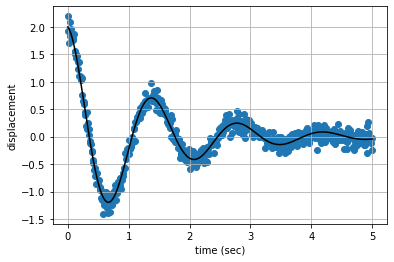

In [9]:
C_0 = 1.5
synthetic_data = compute_displacement(C_0) + 0.1 * np.random.randn(500)

fig, ax = plt.subplots()
ax.plot(tvalues, compute_displacement(C_0), color='black')
ax.scatter(tvalues, synthetic_data)
ax.grid(True)
ax.set_xlabel('time (sec)')
ax.set_ylabel('displacement')
plt.show()

Compute an estimate of C and 95% confidence interval (assuming you know $\sigma_0=0.1$)

In [10]:
# OLS estimate
from scipy.optimize import minimize

def func_to_minimize(theta):
    return np.sum((synthetic_data - compute_displacement(theta)) ** 2)

results_ols = minimize(func_to_minimize, x0=1.)
print(results_ols)
theta_ols = np.squeeze(results_ols.x)
print(theta_ols)

      fun: 5.021954042881015
 hess_inv: array([[0.01626487]])
      jac: array([4.11272049e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([1.49182163])
1.4918216331977265


To compute the variance of the estimator, you need the sensitivity of the displacement with respect to C. The derivative can be computed as:
$$ \frac{\partial h_{i}}{\partial C} = e^{-Ct_i/2} \left[ \frac{Ct_i}{\sqrt{4K-C^2}} \sin{\left( \sqrt{K-C^2/4)} \cdot t_i \right) } - t_i \cos{\left( \sqrt{K-C^2/4)} \cdot t \right) } \right] $$

In [11]:
def compute_sensitivity(C, tvalues):
    K = 20.5
    tmp = np.sqrt(K-C**2/4)
    return np.exp(-C * tvalues / 2) * ( C*tvalues/(2*tmp) * np.sin(tmp*tvalues) - tvalues * np.cos(tmp*tvalues) )

sensitivity_matrix = compute_sensitivity(theta_ols, tvalues).reshape((-1,1))
print(sensitivity_matrix.shape)

(500, 1)


In [12]:
V = 0.1 ** 2 * np.linalg.inv(np.matmul(sensitivity_matrix.T, sensitivity_matrix))
print(np.squeeze(V))

0.00033004840611541576


In [13]:
lb = theta_ols - 1.96 * np.sqrt(np.squeeze(V))
ub = theta_ols + 1.96 * np.sqrt(np.squeeze(V))
print('95% condidence interval = [{}, {}]'.format(lb, ub))

95% condidence interval = [1.4554871643773122, 1.528156102018141]


## Part 2. Bayesian approach

The following uses a importance sampler to sample from the posterior - one could use MCMC instead

In [14]:
# algorithm for importance sampling
def return_posterior_samples(target_density, N, initial_range=(0, 1)):
    initial_samples = initial_range[0] + (initial_range[1]-initial_range[0]) * np.random.rand(N)
    weights = np.array([target_density(s) for s in initial_samples])
    print(initial_samples.shape)
    print(weights.shape)
    return np.random.choice(initial_samples, p=weights / sum(weights), size=N)

Define a function that computes the unnormalized posterior 
$$ p(\theta \vert \mathcal{D}) \propto p(\mathcal{D} \vert \theta) p(\theta) $$
Here the prior is uniform $U(0, 2)$ and the likelihood is typical Gaussian error model.

In [15]:
def unnormalized_posterior(theta):
    # likelihood * prior
    # note: it is usually more stable to use the log posterior instead
    likelihood = np.prod(norm.pdf(x=synthetic_data, loc=compute_displacement(theta), scale=0.1))
    prior = uniform.pdf(x=theta, loc=0, scale=2)
    return prior * likelihood

(10000,)
(10000,)
(10000,)
[1.49866054 1.48149083 1.47714957 ... 1.49389712 1.47404504 1.49021056]


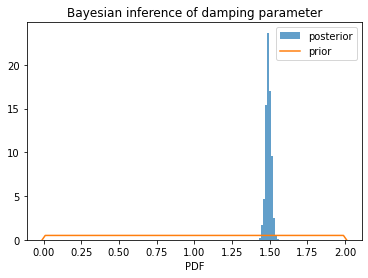

In [16]:
samples = return_posterior_samples(target_density=unnormalized_posterior, N=10000, initial_range=(0, 2))
print(samples.shape)
print(samples)

fig, ax = plt.subplots()
ax.hist(samples, alpha=0.7, density=True, label='posterior')
ax.plot(np.linspace(-0.01, 2.01, 100), uniform.pdf(x=np.linspace(-0.01, 2.01, 100), loc=0, scale=2), label='prior')
ax.set_title('Bayesian inference of damping parameter')
ax.set_xlabel('C')
ax.set_xlabel('PDF')
ax.legend()
plt.show()